#<center> LANGUAGE MODELING WITH RNN </center>
---

<div align="right"> Laura Corso </div>
<div align="right">MAT. 230485</div>

In this code is presented a **baseline Language Model** followed by its **improvement** through some *regularization techniques*. 

In particular, the used regularization techniques include: 

*   *dropout* applied to hidden-to-hidden connections of the RNN
*   *Variational dropout* (see the work by [Merity et al.](https://arxiv.org/abs/1708.02182)).

</br>

The model is trained and tested on the **Penn Tree bank dataset** ([download in .zip](https://deepai.org/dataset/penn-treebank)).

</br>

The improvement of baseline model were inspired by the following codes:

1.   [LSTM and QRNN Language Model Toolkit](https://github.com/salesforce/awd-lstm-lm)
2.   [Hedwig](https://github.com/castorini/hedwig)
3.   [Breaking the Softmax Bottleneck: A High-Rank RNN Language Model](https://arxiv.org/abs/1711.03953)




In [ ]:
# Imports
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from os import path, mkdir
from collections import Counter
import numpy as np
from tqdm.notebook import tqdm
import math
import random
from shutil import unpack_archive as unzip
import matplotlib.pyplot as plt

In [ ]:
# Global variables
device = 'cuda:0'
PAD_TOKEN = 0
BATCH_SIZE = 64
PATH = '/content/gdrive/MyDrive/NLU/Final/' # path in which the .zip of the dataset is located and
                                            # in which the final results of this code will be saved
SAVE = PATH + "Results/"
HD_SIZE = 200                               # size of the hidden layers of the RNN
EMB_DIM = 300                               # size of embedding
LEARNING_RATE_B = 0.0001                    # lr for the baseline model
LEARNING_RATE_I = 0.001                     # lr for the improved model
RUNS = 5                                    # number of runs
EPOCHS_B = 30                               # number of epochs for the baseline model
EPOCHS_I = 40                               # number of epochs for the improved model
PATIENCE = 3                                # early stopping parameter

In [ ]:
# Seeds in order to make this code reproducible
torch.manual_seed(5)
random.seed(5)
np.random.seed(5)

In [ ]:
# Mount of the Google Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load data from the dataset Penn Treebank Corpus

The dataset is composed of 3 file: one for the train set, one for the test set and one for the valid set. Each one is composed of sentences: one sentence for every line.

* Preparation of the dataset

In [ ]:
# Unzip the dataset
if not path.exists(path.join(PATH, "Dataset/")):
  unzip(path.join(PATH, "ptbdataset.zip"), path.join(PATH, "Dataset/"))

# Creation of the folder to save the results
if not path.exists(SAVE):
  mkdir(SAVE)

In [ ]:
"""
Class that contains all the words in the corpus along with their ids.
:attribute word2id: dictionary composed of {word: id}
:attribute id2word: dictionary composed of {id: word}
"""
class Corpus():
  def __init__(self, sents):
    words = []
    for sent in sents:
      for word in sent.split():
        words.append(word)
    self.word2id = self.w2id(words)
    self.id2word = {id: word for word, id in self.word2id.items()}


  """
  Method used to convert each word into the corresponding id.
  :param wds: list of words to convert
  :return vocab: dictionary containing for each word its id
  """
  def w2id(self, wds):
    vocab = {'pad': PAD_TOKEN} # the pad is mapped to 0

    # Mapping of each word
    count = Counter(wds)
    for k, word in count.items():
      vocab[k] = len(vocab)

    return vocab


In [ ]:
"""
Function that load the sentences from the specified .txt file.
:param path: path of the .txt file in which the sentences are contained
:return sents: list of the sentences contained in the specified file
"""
def load_raw_data(path):
  with open(path, 'r') as f:
    sents = []
    for line in f:
      sents.append(line + '<eos>')

    return sents


In [ ]:
# Load the raw data and organize them into a Corpus
trainSet = load_raw_data(path.join(PATH, "Dataset/ptb.train.txt"))
testSet = load_raw_data(path.join(PATH, "Dataset/ptb.test.txt"))
validSet = load_raw_data(path.join(PATH, "Dataset/ptb.valid.txt"))

trainCorpus = Corpus(trainSet)
testCorpus = Corpus(testSet)
validCorpus = Corpus(validSet)

* Preparation of the data to use in the Neural Network

In [ ]:
"""
Function that create a customed pytorch dataset.
:attribute sents: list that contains all the sentences of the dataset
:attribute wordIds: list that contains the sentences in which the words are replaced by their ids
"""
class PennTreeBankD(data.Dataset):
  def __init__(self, dataset, corpus):
    self.sents = []
    self.wordIds = []
    for sent in dataset:
      self.sents.append(sent)
    self.wordIds = self.wordMap(self.sents, corpus.word2id)

  def __getitem__(self, index):
    return torch.Tensor(self.wordIds[index])

  def __len__(self):
    return len(self.sents)

  """
  Method that returns the list of lists of integers to which each word of each sentence has been mapped to.
  :param stns: list of the sentences in the dataset
  :param mapper: dictionary {word: id}
  :return maps: list of lists of the ids of the words in the dataset
  """
  def wordMap(self, stns, mapper):
    maps = []

    for sent in stns:
      seq = []
      for word in sent.split():
        if word in mapper:
          seq.append(mapper[word])
        else:
          seq.append(mapper['<unk>'])

      maps.append(seq)

    return maps


In [ ]:
# Creation of the three datasets
train_dataset = PennTreeBankD(trainSet, trainCorpus)
test_dataset = PennTreeBankD(testSet, trainCorpus) # map the words of the testSet with the ids of the training corpus
valid_dataset = PennTreeBankD(validSet, trainCorpus) # map the words of the validSet with the ids of the training corpus

In [ ]:
"""
Definition of a custom collate_fn function to use in the dataloader to handle padding.
:param batch: current batch extracted by the dataloader
:return: padded input sentences
:return: lenght of each input sentences (without padding)
:return: padded target sentences
:return: lenght of each target sentences (without padding)
"""
def collate_fn(batch):


  """
  Function that unify in a matrix all the padded sentences of the batch. 
  It is applied a right padding in order to obtain sentences that are long as the longest one.
  :param sents: list of setnences of the batch
  :return padded_sents: tensor [n_sentences, maximum_length] containing the padded sentences
  """
  def sentPad(sents):
    lengths = [len(sent) for sent in sents] # list containing the length of each sentence of the dataset

    # Extract the maximum length. It will be used as the reference length for each sentence
    if max(lengths) == 0:
      max_len = 1
    else:
      max_len = max(lengths)

    # Tensor [n_sentences, maximum_length] containing the padded sentences
    padded_sents = torch.LongTensor(len(sents), max_len).fill_(PAD_TOKEN)

    for idx, sent in enumerate(sents):
      padded_sents[idx, :len(sent)] = sent

    padded_sents.detach()

    return padded_sents, lengths

  # Sort the batch in order of increasing sentence's length --> the dataloader 
  # will load, for each batch, the sentences in order of length
  batch.sort(key = lambda x: len(x), reverse = True)
  sequences = [wordId for wordId in batch] # extract the word ids of the batch

  # Create the target and input sequences. 
  targets = [] # list that contains the target sequences --> sequences that start from the second word
  s = [] # list that contains the input sequences --> sequences that have the last word removed
  for seq in sequences:
    targets.append(seq[1:])
    s.append(seq[:-1])

  ps, ls = sentPad(s) # pad the sequences of word ids
  pt, lt = sentPad(targets) # pad the target sequences of word ids

  return ps.to(device), torch.LongTensor(ls).to(device), pt.to(device), torch.LongTensor(lt).to(device)
  

In [ ]:
# Instantiation of the DataLoaders
# Each DataLoader return for each batch:
# - a Tensor containing the matrix [n_sentences, maximum_length] containing the padded id sentences
# - a list containing the length of each sentence before the padding
# - a Tensor containing the matrix [n_sentences, maximum_length] containing the padded id sentences for the target
# - a list containing the length of each sentence before the padding in the targets

train_loader = data.DataLoader(train_dataset, batch_size = BATCH_SIZE, collate_fn = collate_fn, shuffle = True, drop_last = True)
test_loader = data.DataLoader(test_dataset, batch_size = BATCH_SIZE, collate_fn = collate_fn, drop_last = True)
valid_loader = data.DataLoader(valid_dataset, batch_size = BATCH_SIZE, collate_fn = collate_fn, drop_last = True)

In [ ]:
"""
Function that given a list of sentences expressed in word ids, converts them into actual words.
:param e_sentences: encoded sentences with word ids
:param corpus: corpus from which the mapping is done
:return d_sents: list containing the lists of words (each list is a sentence)
"""
def decoder(e_sentences, corpus):
  d_sents = [] # list containing the lists of words (each list is a sentence)
  for sentence in e_sentences:
    sent = [] # list containing the words of the current sentence
    for word_id in sentence:
      if word_id in corpus.id2word:
        sent.append(corpus.id2word[word_id])
      else:
        sent.append("<unk>")

    d_sents.append(sent)
  
  return d_sents

</br>

---

# Model for the baseline

#### Definition of the Neural Network

Here a **single-layer LSTM** is used. In addition, an embedding layer is used in order to convert the word ids into vector and the weights of the hidden layers are initialized at the beginning of every run of the training.

In [ ]:
"""
Class that define the structure of the neural network.
:attribute hidden_size: the number of features in the hidden state
:attribute embedding_dim: the size of each embedding vector
:attribute num_embeddings: size of the dictionary of embeddings
:attribute num_layers: number of recurrent layers. Default: 1
:attribute padding_idx: when the input is equal to the specified value its embedding will
                        be a sequence of zeros of 'embedding_dim' length
"""
class Network(nn.Module):
  def __init__(self, hidden_size, embedding_dim, num_embeddings, num_layers = 1, padding_idx = 0):
    super(Network, self).__init__()
    self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx = padding_idx)
    self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers)
    self.linear = nn.Linear(hidden_size, num_embeddings)

  """
  Function that specify how to do a forward pass in the network.
  :param sents_ids: Tensor [batch_size, maximum_length] containing the sentences of the batch with word ids
  :param sent_lengths: length of each word in the batch before the padding
  """
  def forward(self, sents_ids, sent_lengths):
    embed = self.embedding(sents_ids) # Tensor [batch_size, maximum_length, embedding_dim]
    embed = embed.permute(1, 0, 2) # Tensor [maximum_length, batch_size, embedding_dim]

    # Pack the input in order to remove from the computation the padding embeddings
    packed_input = pack_padded_sequence(embed, sent_lengths.cpu().numpy())

    # Pass the input into the lstms. Each will return the packed output features,
    # a tensor containing the final hidden state for each element in the sequence and
    # a tensor containing the final cell state for each element in the sequence
    packed_output, (h_n1, cell1) = self.lstm(packed_input)

    output, input_sizes = pad_packed_sequence(packed_output)

    # Decode hidden states of all time steps
    output = self.linear(output)
    output = output.permute(1, 2, 0)
    
    return output, input_sizes

In [ ]:
"""
Function to randomly initialize the weights of the RNN. It is applied recursively 
  to every submodule.
:param module: current submodule of the network

Note: In the network we used
      for name, param in net.named_parameters():
        print(name)

      return:
        embedding.weight
        rnn.weight_ih_l0
        rnn.weight_hh_l0
        rnn.bias_ih_l0
        rnn.bias_hh_l0
"""
def init_weights(module):
  for m in module.modules():
    if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
      for name, param in m.named_parameters():
        if 'weight_ih' in name:
          for idx in range(4):
            mul = param.shape[0]//4
            torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
        elif 'weight_hh' in name:
          for idx in range(4):
            mul = param.shape[0]//4
            torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
        elif 'bias' in name:
          param.data.fill_(0)
    else:
      if type(m) in [nn.Linear]:
        torch.nn.init.uniform_(m.weight, -0.01, 0.01)
        if m.bias != None:
            m.bias.data.fill_(0.01)

#### Implementation of the model

In [ ]:
# Training step
"""
Function that defines the training procedure.
:param net: network to train
:param data_loader: dataloader for the training procedure
:param optimizer: optimizer used to update the parameters
:param cost_function: cost function for the loss computation
:return loss_array: training loss for each batch in the dataloader
"""
def training_step(net, data_loader, optimizer, cost_function):
  loss_array = []
  
  # Set the network to training mode
  net.train() 

  # Iterate over the training set
  for idx, (sample, length, target, _ )in enumerate(data_loader):
    # Forward pass
    output, _ = net(sample, length)

    # Loss computation
    loss = cost_function(output, target)
    loss_array.append(loss.item())

    if idx == 0:
      print("Loss in the first batch: ", loss.item())
      print("ppl in the first batch: ", np.exp(loss.item()))
      
    # Backward pass
    loss.backward()

    # Parameters update
    optimizer.step()

    # Gradients reset
    optimizer.zero_grad()

  print("\nLoss in the last batch: ", loss_array[-1])
  print("ppl in the last batch: ", np.exp(loss_array[-1]))

  return loss_array


In [ ]:
# Test step
"""
Function that defines the test procedure.
:param net: network to test
:param data_loader: dataloader for the test procedure
:param cost_function: cost function for the loss computation
:return losses: test loss for batch in the dataloader
"""
def test_step(net, data_loader, cost_function):
  losses = []

  # Set the network to evaluation mode
  net.eval() 

  # Disable gradient computation 
  with torch.no_grad():
    # Iterate over the test set
    for sample, length, target, _ in data_loader:
      # Forward pass
      output, _ = net(sample, length)

      # Loss computation
      loss = cost_function(output, target)
      losses.append(loss.item())

  return losses

#### Training and test
Since we have a small corpora, to have reliable results, the model is trained and tested from scratch for several runs.
The results of the runs are then averaged and the standard deviation is computed.

In the training, for each run a fixed number of epochs are executed and an early stopping technique is used. Therefore, every five epochs a test step is computed on the valid set. If the performance of the model is deteriorating, the training continue for a fixed number of steps (*PATIENCE*) and then it is interrupted.

In [ ]:
lossTs = [] # list that contains the losses computed on the test set in every run

for run in tqdm(range(0, RUNS), desc = 'Run: '):
  # Instantiation of the model
  net = Network(HD_SIZE, EMB_DIM, len(trainCorpus.word2id), padding_idx = PAD_TOKEN).to(device)
  net.apply(init_weights)

  # Cost function
  cost_function = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN) # the padding doesn't contribute to the input gradient

  # Optimizer
  optimizer = optim.Adam(net.parameters(), lr = LEARNING_RATE_B)

  # Training
  sampled_epochs = [] # list containing the number of the epochs in which a test on the valid set is performed
  losses_train = [] # list that contains the means of the losses for each training step in the sampled epochs
  losses_eval = [] # list that contains the means of the losses for each evaluation step (test step on the validation set) in the sampled epochs
  best_loss = math.inf # value of the best found loss
  patience = PATIENCE

  for epoch in tqdm(range(EPOCHS_B), desc = 'Epoch: '):
    print("\n\nEpoch ", epoch)
    print("\n--------- TRAIN --------")
    loss = training_step(net, train_loader, optimizer, cost_function)

    print("\nAverage test loss along batches: ", sum(loss)/len(loss))
    print("Averge test ppl along batches: ", np.exp(sum(loss)/len(loss)))

    if epoch % 5 == 0:
      sampled_epochs.append(epoch)
      losses_train.append(np.asarray(loss).mean())

      # Compute the loss on the valid set
      print("\n--------- VALIDATION --------")
      lossV = test_step(net, valid_loader, cost_function)
      losses_eval.append(sum(lossV)/len(lossV))
      print("Average validation loss along batches: ", sum(lossV)/len(lossV))
      print("Average validation ppl along batches: : ", np.exp(sum(lossV)/len(lossV)))

      # Check whether the performace of the model is deteriorating
      if best_loss > losses_eval[-1]:
        best_loss = losses_eval[-1]
      else:
        patience = patience - 1

      # Early stopping
      if patience <= 0:
        break

  # Testing
  print("\n--------- TEST --------")
  lossT = test_step(net, test_loader, cost_function)
  print("Average test loss along batches: ", sum(lossT)/len(lossT))
  print("Average test ppl along batches: ", np.exp(sum(lossT)/len(lossT)))
  lossTs.append(lossT)

lossTs = np.asarray(lossTs)
print('\n\nFinal average loss along runs: ', lossTs.mean(), "+/-", lossTs.std())
print('Final average ppl along runs: ', np.exp(lossTs.mean()))

Run:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]



Epoch  0

--------- TRAIN --------
Loss in the first batch:  9.210811614990234
ppl in the first batch:  10004.713540664843

Loss in the last batch:  6.596127986907959
ppl in the last batch:  732.2543943919708

Average test loss along batches:  7.109997042419341
Averge test ppl along batches:  1224.143925581985

--------- VALIDATION --------
Average validation loss along batches:  6.622444556309627
Average validation ppl along batches: :  751.7806227397086


Epoch  1

--------- TRAIN --------
Loss in the first batch:  6.653218746185303
ppl in the first batch:  775.275729582685

Loss in the last batch:  6.6288251876831055
ppl in the last batch:  756.5927937856459

Average test loss along batches:  6.57081218905282
Averge test ppl along batches:  713.9494696613702


Epoch  2

--------- TRAIN --------
Loss in the first batch:  6.570376396179199
ppl in the first batch:  713.6384033555294

Loss in the last batch:  6.351897239685059
ppl in the last batch:  573.5798959015605

Average test lo

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]



Epoch  0

--------- TRAIN --------
Loss in the first batch:  9.210820198059082
ppl in the first batch:  10004.799412178483

Loss in the last batch:  6.700233459472656
ppl in the last batch:  812.5955111442021

Average test loss along batches:  7.10125282148248
Averge test ppl along batches:  1213.4864044054127

--------- VALIDATION --------
Average validation loss along batches:  6.62128210067749
Average validation ppl along batches: :  750.907218865653


Epoch  1

--------- TRAIN --------
Loss in the first batch:  6.658405780792236
ppl in the first batch:  779.3075592020244

Loss in the last batch:  6.628448486328125
ppl in the last batch:  756.3078379300565

Average test loss along batches:  6.568559224202753
Averge test ppl along batches:  712.3427771919394


Epoch  2

--------- TRAIN --------
Loss in the first batch:  6.435847759246826
ppl in the first batch:  623.8112004751666

Loss in the last batch:  6.2878875732421875
ppl in the last batch:  538.0156092636922

Average test lo

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]



Epoch  0

--------- TRAIN --------
Loss in the first batch:  9.210582733154297
ppl in the first batch:  10002.423905499572

Loss in the last batch:  6.611626148223877
ppl in the last batch:  743.6913883865839

Average test loss along batches:  7.105494102930914
Averge test ppl along batches:  1218.6440716079137

--------- VALIDATION --------
Average validation loss along batches:  6.61511153441209
Average validation ppl along batches: :  746.2879624831261


Epoch  1

--------- TRAIN --------
Loss in the first batch:  6.575214862823486
ppl in the first batch:  717.0996858636265

Loss in the last batch:  6.673388957977295
ppl in the last batch:  791.0719765303562

Average test loss along batches:  6.559817826548305
Averge test ppl along batches:  706.1430423617937


Epoch  2

--------- TRAIN --------
Loss in the first batch:  6.486054420471191
ppl in the first batch:  655.9302259927223

Loss in the last batch:  6.350910186767578
ppl in the last batch:  573.0140215118294

Average test l

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]



Epoch  0

--------- TRAIN --------
Loss in the first batch:  9.210858345031738
ppl in the first batch:  10005.181072267635

Loss in the last batch:  6.820371627807617
ppl in the last batch:  916.3254788421674

Average test loss along batches:  7.105370387276195
Averge test ppl along batches:  1218.4933155843576

--------- VALIDATION --------
Average validation loss along batches:  6.624696172200716
Average validation ppl along batches: :  753.4752510465466


Epoch  1

--------- TRAIN --------
Loss in the first batch:  6.51230525970459
ppl in the first batch:  673.3769384500234

Loss in the last batch:  6.54074764251709
ppl in the last batch:  692.8043544479538

Average test loss along batches:  6.577591650743644
Averge test ppl along batches:  718.8061068315928


Epoch  2

--------- TRAIN --------
Loss in the first batch:  6.443087577819824
ppl in the first batch:  628.3438684389773

Loss in the last batch:  6.412243366241455
ppl in the last batch:  609.2589400393347

Average test lo

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]



Epoch  0

--------- TRAIN --------
Loss in the first batch:  9.210650444030762
ppl in the first batch:  10003.101201318876

Loss in the last batch:  6.539794445037842
ppl in the last batch:  692.1442897196765

Average test loss along batches:  7.100901458542823
Averge test ppl along batches:  1213.060105152392

--------- VALIDATION --------
Average validation loss along batches:  6.6219818867169895
Average validation ppl along batches: :  751.43287715709


Epoch  1

--------- TRAIN --------
Loss in the first batch:  6.594475269317627
ppl in the first batch:  731.0451841904904

Loss in the last batch:  6.462896347045898
ppl in the last batch:  640.9146822487149

Average test loss along batches:  6.574858546438464
Averge test ppl along batches:  716.8442170124307


Epoch  2

--------- TRAIN --------
Loss in the first batch:  6.463304042816162
ppl in the first batch:  641.1760337260936

Loss in the last batch:  6.400740146636963
ppl in the last batch:  602.2906563439994

Average test lo

</br>

---

# Model to improve the baseline

</br>

Here a **3-layers LSTM** is used. In addition, an embedding layer is used in order to convert the word ids into vector.

</br>

To improve the baseline two main regularization technique are used: 

*   *dropout* to the hidden-to-hidden connections of the RNN

*   *Variational dropout*.

</br>

Moreover, in order to make the training process more stable, the following methods were applied:


*   *zeroing* of the *initial hidden state* at the beginning of every training epoch
*   a *weight decay* (L2 penalty) is added to the optimizer
*   an *adaptive learning rate* is designed. It decreases the learning rate if no improvement on the loss value is observed for 5 epochs.

#### Definition of the Neural Network






In [ ]:
"""
Class for the implementation of the Variational dropout.
"""
class VariationalDropout(nn.Module):
  def __init__(self):
    super().__init__()

  """
  Function that returns the dropout version of the input/output matrix of a forward or backward pass.
  :param samples: input/output matrix to mask with the dropout
  :param dropout: probability of dropout
  :return masked_s: dropout input/output matrix
  """
  def forward(self, samples, dropout = 0.5):
    new_samples = samples.data.new(1, samples.size(1), samples.size(2))
    change = new_samples.bernoulli_(1 - dropout)
    m = torch.tensor(torch.div(change, (1 - dropout)), requires_grad = False)
    mask = m.expand_as(samples)
    masked_s = mask*samples

    return masked_s

In [ ]:
"""
Class that defines the structure of the neural network.
:attribute hidden_size: the number of features in the hidden state
:attribute embedding_dim: the size of each embedding vector
:attribute num_embeddings: size of the dictionary of embeddings
:attribute num_layers: number of recurrent layers. Default: 3
:attribute padding_idx: when the input is equal to the specified value its embedding will
                        be a sequence of zeros of 'embedding_dim' length
"""
class ImprovedNetwork(nn.Module):
  def __init__(self, hidden_size, embedding_dim, num_embeddings, num_layers = 3, padding_idx = 0):
    super(ImprovedNetwork, self).__init__()
    self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx = padding_idx)
    self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, dropout = 0.2) # here the hidden-to-hidden dropout is defined
    self.linear = nn.Linear(hidden_size, num_embeddings)
    self.var = VariationalDropout() # here the Variational dropout is defined

    self.hidden_size = hidden_size
    self.num_layers = num_layers

  """
  Function that specify how to do a forward pass in the network.
  :param sents_ids: Tensor [batch_size, maximum_length] containing the sentences of the batch with word ids
  :param sent_lengths: length of each word in the batch before the padding
  :param hidden: hidden states of the network
  """
  def forward(self, sents_ids, sent_lengths, hidden):
    embed = self.embedding(sents_ids) # embedding of the input. Tensor [batch_size, maximum_length, embedding_dim]
    embed = self.var(embed) # Variational dropout
    embed = embed.permute(1, 0, 2) # Tensor [maximum_length, batch_size, embedding_dim]

    # Pack the input in order to remove from the computation the padding embeddings
    packed_input = pack_padded_sequence(embed, sent_lengths.cpu().numpy())

    # Pass the input into the lstms. Each will return the packed output features,
    # a tensor containing the final hidden state for each element in the sequence and
    # a tensor containing the final cell state for each element in the sequence
    packed_output, hidden = self.lstm(packed_input)

    # Unpack the output in order to add the previously removed padding
    output, input_sizes = pad_packed_sequence(packed_output)
    output = self.var(output) # Variational dropout

    # Decode hidden states of all time steps
    output = self.linear(output)
    output = output.permute(1, 2, 0)

    return output, hidden

  """
  Function that zeroes the initial hidden states.
  :return: the zeroed hidden states
  """
  def init_hidden(self):
    return (torch.zeros(self.num_layers, BATCH_SIZE, self.hidden_size), torch.zeros(self.num_layers, BATCH_SIZE, self.hidden_size))

#### Implementation of the model

In [ ]:
# Training step
"""
Function that defines the training procedure.
:param net: network to train
:param data_loader: dataloader for the training procedure
:param optimizer: optimizer used to update the parameters
:param cost_function: cost function for the loss computation
:return loss_array: training loss for each sample in the dataloader
"""
def training_step(net, data_loader, optimizer, cost_function):
  loss_array = []
  hidden = net.init_hidden()

  # Set the network to training mode
  net.train() 

  # Iterate over the training set
  for idx, (sample, length, target, _ )in enumerate(data_loader):
    # Forward pass
    output, hidden = net(sample, length, hidden)

    # Loss computation
    loss = cost_function(output, target)
    loss_array.append(loss.item())

    if idx == 1:
      print("Loss in the first batch: ", loss.item())
      print("ppl in the first batch: ", np.exp(loss.item()))
      
    # Backward pass
    loss.backward()

    # Parameters update
    #torch.nn.utils.clip_grad_norm_(net.parameters(), 0.25)
    optimizer.step()

    # Gradients reset
    optimizer.zero_grad()

  print("\nLoss in the last batch: ", loss_array[-1])
  print("ppl in the last batch: ", np.exp(loss_array[-1]))

  return loss_array


In [ ]:
# Test step
"""
Function that defines the test procedure

:param net: network to test
:param data_loader: dataloader for the test procedure
:param cost_function: cost function for the loss computation
:param save: boolean. If True then the output words and their perplexity are saved into a file
                      otherwhise not.
             Default: False
:param corpus: corpus used to convert the word id into words. Used in the saving procedure
:return losses: list containing the losses along batches
"""
def test_step(net, data_loader, cost_function, save = False, corpus = trainCorpus):
  losses = [] # list containing the losses along batches
  predictions = [] # list containing the output of the network along batches
  samples = [] # list containing the inputs along batches
  targets = [] # list containing the targets along batches
  ls = [] # list containing the per word losses along batches
  hidden = net.init_hidden()

  # Set the network to evaluation mode
  net.eval() 

  # Disable gradient computation 
  with torch.no_grad():
    # Iterate over the test set
    for sample, length, target, _ in data_loader:
      # Forward pass
      output, hidden = net(sample, length, hidden)

      # Loss computation
      loss = cost_function(output, target)
      losses.append(loss.item())

      if save:
        # Store the samples along batches
        for s in sample:
          samples.append(s.tolist())

        # Store the targets along batches
        for s in target:
          targets.append(s.tolist())

        # Compute the predictions from the current output of the network
        softmax = nn.Softmax(1)
        out_soft = softmax(output)
        max_probs, prediction = out_soft.max(1)

        # Store the predictions along batches
        for pred in prediction.tolist():
          predictions.append(pred)

        # Compute the loss per word
        lf = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN, reduction = "none")
        l = lf(output, target)
        ls.append(l)


    if save:
      d_out = decoder(predictions, corpus) # output word_ids --> words
      d_in = decoder(samples, corpus) # input word_ids --> words
      d_t = decoder(targets, corpus) # target word_ids --> words

      with open(path.join(SAVE, "output.txt"), 'w') as f:
        for sent in d_out:
          for word in sent:
            f.write("%s " % word)
          f.write("\n\n")
      f.close()

      with open(path.join(SAVE, "input.txt"), 'w') as f:
        for sent in d_in:
          for word in sent:
            f.write("%s " % word)
          f.write("\n\n")
      f.close()

      with open(path.join(SAVE, "target.txt"), 'w') as f:
        for sent in d_t:
          for word in sent:
            f.write("%s " % word)
          f.write("\n\n")
      f.close()

      with open(path.join(SAVE, "loss_per_word.txt"), 'w') as f:
        for l in ls:
          for sent in l:
            for l_word in sent:
              f.write("%s " % l_word.item())
            f.write("\n\n")
      f.close()

  return losses

#### Training and test
Since we have a small corpora, to have reliable results the model is trained and tested from scratch for several runs.
The results of the runs are then averaged and the standard deviation is computed.

</br>

In addition, as aforementioned, a weight decay and an adaptive learning rate are applied.

In [ ]:
"""
Function that write a list of losses in a file.
:param losses: list of losses
:param path: name of the file
"""
def loss_to_file(losses, p):
  if not path.exists(path.join(SAVE, "Losses/")):
    mkdir(path.join(SAVE, "Losses/"))

  with open(path.join(SAVE, "Losses/", p + ".txt"), 'w') as f:
    for item in losses:
      f.write("%s\n" % item)

    f.close()

In [ ]:
lossTs = [] # list that contains the losses computed on the test set in every run
lrs = [] # list containing the used learning rates

for run in tqdm(range(0, RUNS), desc = 'Run: '):
  # Instantiation of the model
  net = ImprovedNetwork(HD_SIZE, EMB_DIM, len(trainCorpus.word2id), padding_idx = PAD_TOKEN).to(device)
  net.apply(init_weights)
  net.hidden = net.init_hidden()

  # Cost function
  cost_function = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN) # the padding doesn't contribute to the input gradient

  # Optimizer with weight decay
  optimizer = optim.Adam(net.parameters(), lr = LEARNING_RATE_I, weight_decay = 0.00000000001)

  # Definition of the adaptive learning rate. The lr is reduced by a 0.01 factor if for 5 epochs 
  # no improvement (in the order of 0.1) is observed in the loss value
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.1, patience = 5, threshold = 0.1, threshold_mode = "abs")

  # Training
  sampled_epochs = [] # list containing the number of the epochs in which a test on the valid set is performed
  losses_train = [] # list that contains the means of the losses for each training step in one run
  losses_eval = [] # list that contains the means of the losses for each evaluation step (test step on the validation set) in the sampled epochs

  for epoch in tqdm(range(EPOCHS_I), desc = 'Epoch: '):
    print("\n\nEpoch ", epoch)
    print("\n--------- TRAIN --------")
    loss = training_step(net, train_loader, optimizer, cost_function)
    losses_train.append(np.asarray(loss).mean())

    lrs.append(optimizer.param_groups[0]['lr'])
    print("\nlr: ", lrs[-1])
    scheduler.step(np.asarray(loss).mean())
    
    print("\nAverage test loss along batches: ", sum(loss)/len(loss))
    print("Averge test ppl along batches: ", np.exp(sum(loss)/len(loss)))

    if epoch % 5 == 0:
      sampled_epochs.append(epoch)

      # Compute the loss on the valid set
      print("\n--------- VALIDATION --------")
      lossV = test_step(net, valid_loader, cost_function)
      losses_eval.append(np.asarray(lossV).mean())
      print("Average validation loss along batches: ", sum(lossV)/len(lossV))
      print("Average validation ppl along batches: : ", np.exp(sum(lossV)/len(lossV)))

  # Print the losses along epochs in a file
  loss_to_file(losses_train, "train"+str(run))
  loss_to_file(sampled_epochs, "s_epochs"+str(run))
  loss_to_file(losses_eval, "eval"+str(run))

  # Testing
  print("\n--------- TEST --------")
  if run == RUNS - 1:
    lossT = test_step(net, test_loader, cost_function, True)
    print("Average test loss along batches: ", sum(lossT)/len(lossT))
    print("Average test ppl along batches: ", np.exp(sum(lossT)/len(lossT)))
    lossTs.append(np.asarray(lossT).mean())
  else:
    lossT = test_step(net, test_loader, cost_function)
    print("Average test loss along batches: ", sum(lossT)/len(lossT))
    print("Average test ppl along batches: ", np.exp(sum(lossT)/len(lossT)))
    lossTs.append(np.asarray(lossT).mean())

lossTs = np.asarray(lossTs)
print('\n\nFinal average loss along runs: ', lossTs.mean(), "+/-", lossTs.std())
print('Final average ppl along runs: ', np.exp(lossTs.mean()))

Run:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]



Epoch  0

--------- TRAIN --------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loss in the first batch:  9.208457946777344
ppl in the first batch:  9981.19345452262

Loss in the last batch:  6.630674839019775
ppl in the last batch:  757.9935216877559

lr:  0.001

Average test loss along batches:  6.709643318228526
Averge test ppl along batches:  820.2780090523963

--------- VALIDATION --------
Average validation loss along batches:  6.594133120316726
Average validation ppl along batches: :  730.7951005964717


Epoch  1

--------- TRAIN --------
Loss in the first batch:  6.541275978088379
ppl in the first batch:  693.1704843435596

Loss in the last batch:  6.400829315185547
ppl in the last batch:  602.344364122138

lr:  0.001

Average test loss along batches:  6.5145645025476835
Averge test ppl along batches:  674.8999802917882


Epoch  2

--------- TRAIN --------
Loss in the first batch:  6.363516807556152
ppl in the first batch:  580.2835176015511

Loss in the last batch:  5.943002700805664
ppl in the last batch:  381.0774749597424

lr:  0.001

Average test loss

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]



Epoch  0

--------- TRAIN --------
Loss in the first batch:  9.208430290222168
ppl in the first batch:  9980.917412912322

Loss in the last batch:  6.630721092224121
ppl in the last batch:  758.0285821278298

lr:  0.001

Average test loss along batches:  6.702695182469338
Averge test ppl along batches:  814.5983604195939

--------- VALIDATION --------
Average validation loss along batches:  6.5835875272750854
Average validation ppl along batches: :  723.1289260928494


Epoch  1

--------- TRAIN --------
Loss in the first batch:  6.690536975860596
ppl in the first batch:  804.7542697586575

Loss in the last batch:  6.383333683013916
ppl in the last batch:  591.897621346452

lr:  0.001

Average test loss along batches:  6.449563937281546
Averge test ppl along batches:  632.4264550761251


Epoch  2

--------- TRAIN --------
Loss in the first batch:  6.300442695617676
ppl in the first batch:  544.8130430943672

Loss in the last batch:  5.955663204193115
ppl in the last batch:  385.932778

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]



Epoch  0

--------- TRAIN --------
Loss in the first batch:  9.208450317382812
ppl in the first batch:  9981.117304350353

Loss in the last batch:  6.51194429397583
ppl in the last batch:  673.1339163166753

lr:  0.001

Average test loss along batches:  6.697106775809278
Averge test ppl along batches:  810.0587499261485

--------- VALIDATION --------
Average validation loss along batches:  6.561234079874479
Average validation ppl along batches: :  707.1438283102283


Epoch  1

--------- TRAIN --------
Loss in the first batch:  6.471914291381836
ppl in the first batch:  646.720554347008

Loss in the last batch:  6.198537349700928
ppl in the last batch:  492.02884838436927

lr:  0.001

Average test loss along batches:  6.41963409470278
Averge test ppl along batches:  613.778488231992


Epoch  2

--------- TRAIN --------
Loss in the first batch:  6.326158046722412
ppl in the first batch:  559.004792644673

Loss in the last batch:  6.028243541717529
ppl in the last batch:  414.9854841709

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]



Epoch  0

--------- TRAIN --------
Loss in the first batch:  9.207806587219238
ppl in the first batch:  9974.69422566192

Loss in the last batch:  6.81000280380249
ppl in the last batch:  906.8733496377636

lr:  0.001

Average test loss along batches:  6.706436116582908
Averge test ppl along batches:  817.6514263135903

--------- VALIDATION --------
Average validation loss along batches:  6.582949161529541
Average validation ppl along batches: :  722.6674526669044


Epoch  1

--------- TRAIN --------
Loss in the first batch:  6.627122402191162
ppl in the first batch:  755.3055747930135

Loss in the last batch:  6.161583423614502
ppl in the last batch:  474.1783058382899

lr:  0.001

Average test loss along batches:  6.4666731499101475
Averge test ppl along batches:  643.3398674968823


Epoch  2

--------- TRAIN --------
Loss in the first batch:  6.332119941711426
ppl in the first batch:  562.3474749762244

Loss in the last batch:  6.109443664550781
ppl in the last batch:  450.0882454

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]



Epoch  0

--------- TRAIN --------
Loss in the first batch:  9.2086181640625
ppl in the first batch:  9982.792742353879

Loss in the last batch:  6.734975337982178
ppl in the last batch:  841.3227351149862

lr:  0.001

Average test loss along batches:  6.716543628744883
Averge test ppl along batches:  825.9577554952479

--------- VALIDATION --------
Average validation loss along batches:  6.606441928790166
Average validation ppl along batches: :  739.8459055642542


Epoch  1

--------- TRAIN --------
Loss in the first batch:  6.6254167556762695
ppl in the first batch:  754.0183885261341

Loss in the last batch:  6.190847873687744
ppl in the last batch:  488.2599134949303

lr:  0.001

Average test loss along batches:  6.492888264097217
Averge test ppl along batches:  660.4281019725355


Epoch  2

--------- TRAIN --------
Loss in the first batch:  6.34196662902832
ppl in the first batch:  567.912086258718

Loss in the last batch:  5.928519248962402
ppl in the last batch:  375.597934817

In [ ]:
# Save the model
torch.save(net, path.join(SAVE, "Network"))

</br>

---

# Statistics

In this section some statistic about the obtained results are computed.

#### Definition of the functions

In [ ]:
"""
Function that load the item from the specified .txt file organized by sentences.
:param source: path of the .txt file in which the sentences are contained
:return sents: list of the words contained in the specified file
"""
def read_words(source):
  with open(source, 'r') as f:
    sents = []
    for line in f:
      for word in line.split():
        sents.append(word)
  f.close()

  return sents

In [ ]:
"""
Function that load the losses from the specified .txt file organized with one loss per row.
:param source: path of the .txt file in which the losses are contained
:return sents: list of the losses contained in the specified file
"""
def read_losses(source):
  with open(source, 'r') as f:
    losses = []
    for line in f:
      losses.append(float(line[:-1])) # exclude the '\n' character
  f.close()

  return losses

In [ ]:
"""
Function that displays the loss plot over epochs.
:param n_epochs: integer number of epochs performed
:param losses: list containing all the losses over n_epochs
"""
def lossPlot(n_epochs, losses):
  fig = plt.figure(figsize = (15, 10))
  plt.plot(n_epochs, losses, 'royalblue', label = "Loss")
  plt.title("Loss over epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  mi = np.min(losses) - 0.05
  ma = np.max(losses) + 0.05
  plt.ylim([mi, ma])
  plt.legend()
  plt.show()
  n = "lossPlot.png"
  fig.savefig(path.join(SAVE, n))

In [ ]:
"""
Function that displays the ppl plot over epochs.
:param n_epochs: integer number of epochs performed
:param ppls: list containing all the losses over n_epochs
"""
def pplPlot(n_epochs, ppls):
  fig = plt.figure(figsize = (15, 10))
  plt.plot(n_epochs, ppls, 'blueviolet', label = "PPL")
  plt.title("Perplexity over epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Perplexity")
  mi = np.min(ppls) - 10
  ma = np.max(ppls) + 10
  plt.ylim([mi, ma])
  plt.legend()
  plt.show()
  n = "pplPlot.png"
  fig.savefig(path.join(SAVE, n))

In [ ]:
"""
Function that computes the words with the highest and lowest mean perplexity.
"""
def min_max_ppl():
  losses = np.array(read_words(path.join(SAVE, "loss_per_word.txt")), dtype = float)
  words = read_words(path.join(SAVE, "output.txt"))

  cum_losses = np.zeros(len(trainCorpus.id2word)) # sum of the losses per word
  n_word = np.zeros(len(trainCorpus.id2word)) # numbers of words for each type of word in the trainCorpus

  for idx, loss in enumerate(losses):
    w_id = trainCorpus.word2id[words[idx]] 
    cum_losses[w_id] = cum_losses[w_id] + loss
    n_word[w_id] = n_word[w_id] + 1

  # Since the train contains more words than the test (but not viceversa) some
  # elements in cum_losses and n_word will be 0.
  # Therefore to obtain the mean loss per word we have to exclude division by 0
  mean_losses = np.zeros(len(trainCorpus.id2word))
  for idx in range(len(mean_losses)):
    if n_word[idx] != 0:
      mean_losses[idx] = cum_losses[idx] / n_word[idx]

  max_loss = np.max(mean_losses)
  p_max = np.argmax(mean_losses)
  word_max = words[p_max]

  min_loss = np.min(mean_losses[mean_losses != 0.])
  p_min = np.argmin(mean_losses[mean_losses != 0.])
  word_min = words[p_min]

  print("The word with the highest perplexity (", np.exp(max_loss), ") is: ", word_max)
  print("The word with the lowest perplexity (", min_loss, ") is: ", word_min)

In [ ]:
def len_ppl():
  with open(path.join(SAVE, "loss_per_word.txt"), 'r') as f:
    sents = []
    for line in f:
      words = []
      for word in line.split():
        if float(word) != 0:
          words.append(word)
      
      if len(words) != 0:
        sents.append(words)
  f.close()

  lengths = np.zeros(len(sents))
  means = np.zeros(len(sents))
  n = np.zeros(len(sents))
  for sent in sents:
    lengths[len(sent)] = len(sent)
    means[len(sent)] = means[len(sent)] + np.mean(np.array(sent, dtype = float))
    n[len(sent)] = n[len(sent)] + 1

  lengths = lengths[lengths != 0]
  means = means[means != 0]
  n = n[n != 0]
  m = np.divide(means, n)

  # Creation of the list containing a color of the bar for each class
  fill = []
  for i in range(len(lengths)):
    fill.append(np.random.rand(len(lengths) ,3))

  # Visualization
  fig = plt.figure(figsize = (15, 20))
  ax1 = plt.subplot2grid(shape = (2, 1), loc = (0, 0))
  l_str = []
  for length in lengths:
    l_str.append(str(length))
  ax1.bar(l_str, np.exp(m), color = np.random.rand(len(lengths), 3))
  ax1.set_xlabel("Lengths")
  ax1.set_ylabel("Mean perplexity")
  ax1.set_title("Perplexiy per sentence's length")
  plt.setp(ax1.get_xticklabels(), rotation=90)

  ax2 = plt.subplot2grid(shape = (2, 1), loc = (1, 0))
  ax2.bar(l_str, n, color = np.random.rand(len(lengths), 3))
  ax2.set_ylabel("Number of occurrence")
  ax2.set_xlabel("Lengths")
  ax2.set_title("Number of occurrences of each sentence length")
  plt.setp(ax2.get_xticklabels(), rotation=90)


  name = "length_vs_ppl.png"
  fig.savefig(path.join(SAVE, name))
  print("The sentences of length {} are the one with higher perplexity ({})".format(lengths[np.argmax(m)], np.max(np.exp(m))))
  print("The sentences of length {} are the one with occur more often ({})".format(lengths[np.argmax(n)], np.max(n)))
  print("The sentences of length {} are the one with lower perplexity ({})".format(lengths[np.argmin(m)], np.min(np.exp(m))))
  print("The sentences of length {} are the one with occur less often ({})".format(lengths[np.argmin(n)], np.min(n)))

#### Computation of the statistics

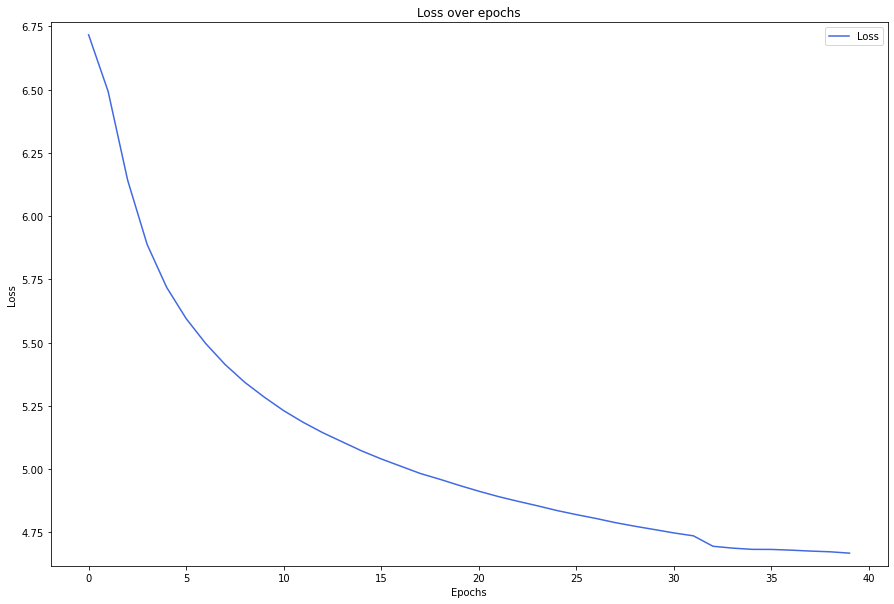

In [ ]:
l = read_losses(path.join(SAVE, "Losses/", ("train" + str(RUNS - 1) + ".txt"))) # read the losses of the last run
lossPlot(range(EPOCHS_I), l)

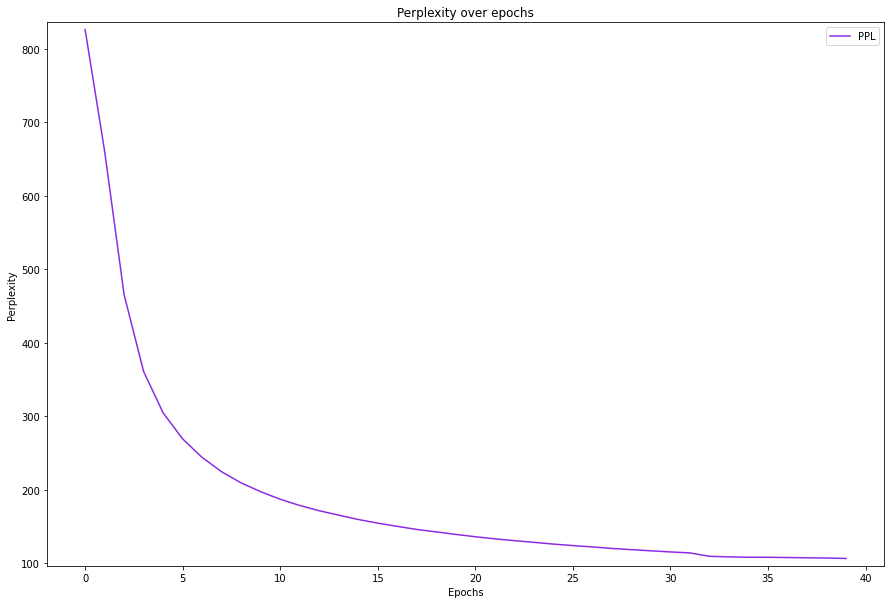

In [ ]:
pplPlot(range(EPOCHS_I), np.exp(l))

In [ ]:
min_max_ppl()

The word with the highest perplexity ( 131857360.33099522 ) is:  by
The word with the lowest perplexity ( 8.785339014139026e-05 ) is:  <unk>


The sentences of length 58.0 are the one with higher perplexity (631.968865171619)
The sentences of length 18.0 are the one with occur more often (155.0)
The sentences of length 1.0 are the one with lower perplexity (22.675967345927006)
The sentences of length 58.0 are the one with occur less often (1.0)


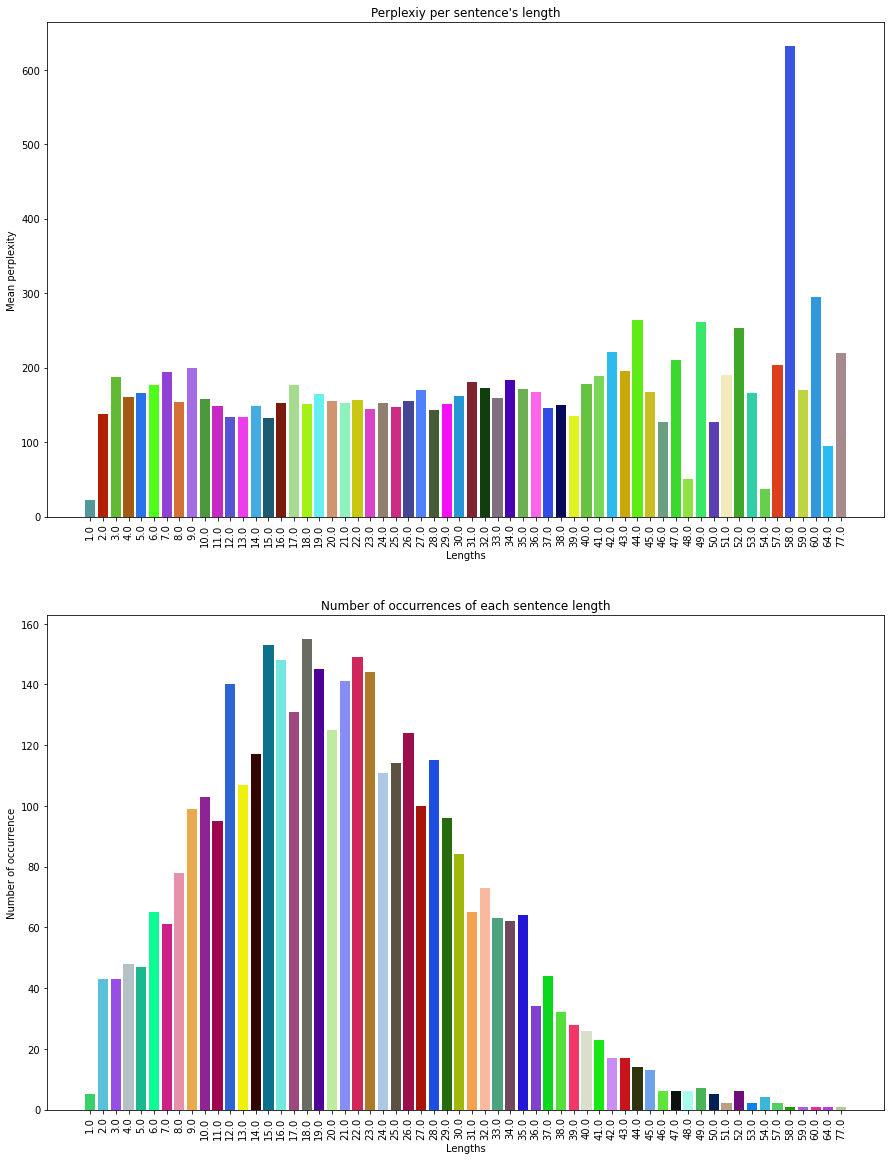

In [ ]:
len_ppl()